     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313500 sha256=145d3e92c56574aa5db4b324a2d8246cb32832c0d352b655cdd8c0661a7fa3c2
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [2]:
!wget -O news.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1hIVVpBqM6VU4n3ERkKq4tFaH4sKN0Hab"
!unzip news.zip

Archive:  news.zip
  inflating: news.csv                


In [3]:
!pip install fasttext==0.9.3
!pip install torchtext==0.6.0
!pip install sacremoses==0.0.5
!pip install rouge-score==0.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313503 sha256=31cd8f9a65cf6a34b2b3e4dfe2dab7a1def3c1a805a9f4cf0c3c6ef62ec8aacc
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchtext.data import Field, Example, Dataset, BucketIterator

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from tqdm.auto import tqdm

import fasttext
import fasttext.util

from google.colab import drive
import os

import gzip
import shutil

import math

from rouge_score import rouge_scorer



if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

gzip_path = '/content/drive/MyDrive/cc.ru.300.bin.gz'
bin_path = '/content/drive/MyDrive/cc.ru.300.bin'

with gzip.open(gzip_path, 'rb') as f_in:
    with open(bin_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
ft_model = fasttext.load_model(bin_path)
embedding_dim = ft_model.get_dimension()

In [7]:

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

word_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN, lower=True)
fields = [('source', word_field), ('target', word_field)]


data = pd.read_csv('news.csv', delimiter=',')

examples = []
for _, row in tqdm(data.iterrows(), total=len(data)):
    source_text = word_field.preprocess(row.text)
    target_text = word_field.preprocess(row.title)
    examples.append(Example.fromlist([source_text, target_text], fields))



dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

word_field.build_vocab(train_dataset, min_freq=7)
print('Vocab size =', len(word_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(16, 32), shuffle=True, device=DEVICE, sort=False
)

print('Finished preparing dataset')



  0%|          | 0/74278 [00:00<?, ?it/s]

Train size = 63136
Test size = 11142
Vocab size = 55953
Finished preparing dataset


In [8]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate):
        super().__init__()
        self._norm = LayerNorm(size)
        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, sublayer):
        return inputs + self._dropout(sublayer(self._norm(inputs)))


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()

        self._gamma = nn.Parameter(torch.ones(features))
        self._beta = nn.Parameter(torch.zeros(features))
        self._eps = eps

    def forward(self, inputs):
        mean = inputs.mean(-1, keepdim=True)
        std = inputs.std(-1, keepdim=True)
        return self._gamma * (inputs - mean) / (std + self._eps) + self._beta


class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, mask):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self._dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, heads_count, d_model, dropout_rate=0.1):
        super().__init__()

        assert d_model % heads_count == 0

        self._d_k = d_model // heads_count
        self._heads_count = heads_count
        self._attention = ScaledDotProductAttention(dropout_rate)
        self._attn_probs = None

        self._w_q = nn.Linear(d_model, d_model)
        self._w_k = nn.Linear(d_model, d_model)
        self._w_v = nn.Linear(d_model, d_model)
        self._w_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        query = self._w_q(query).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        key = self._w_k(key).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        value = self._w_v(value).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        x, self._attn_probs = self._attention(query, key, value, mask)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self._heads_count * self._d_k)
        x = self._w_o(x)
        return x


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        return self.w_2(self.dropout(F.relu(self.w_1(inputs))))


class EncoderBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, mask):
        outputs = self._self_attention_block(inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, mask))
        return self._feed_forward_block(outputs, self._feed_forward)





class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, dim=-1, ignore_index=None):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.dim = dim
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        num_classes = pred.size(self.dim)
        pred = pred.log_softmax(dim=self.dim)

        if self.ignore_index is not None:
            mask = target == self.ignore_index
            target = target.masked_fill(mask, 0)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)

        if self.ignore_index is not None:
            true_dist[mask] = 0

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [9]:
losses = []
PPXs = []

In [10]:

class Encoder(nn.Module):
    def __init__(self, emb, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()

        self._emb = emb

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)

        for block in self._blocks:
            inputs = block(inputs, mask)

        return self._norm(inputs)


class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, encoder_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._encoder_attn = encoder_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        outputs = self._self_attention_block(
            inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, target_mask)
        )
        outputs = self._attention_block(
            outputs, lambda inputs: self._encoder_attn(inputs, encoder_output, encoder_output, source_mask)
        )
        return self._feed_forward_block(outputs, self._feed_forward)


class Decoder(nn.Module):
    def __init__(self, emb, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()

        self._emb = emb
        vocab_size = emb[0].num_embeddings

        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)
        self._out_layer = nn.Linear(d_model, vocab_size)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        inputs = self._emb(inputs)
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
        return self._out_layer(self._norm(inputs))




class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, vocab, ft_model, source_vocab_size, d_model=300, d_ff=1024,
                 blocks_count=4, heads_count=10, dropout_rate=0.1):
        super(EncoderDecoder, self).__init__()

        self.d_model = d_model


        weight_matrix = self._load_fasttext_embeddings(ft_model, vocab)

        self._emb = nn.Sequential(
            nn.Embedding.from_pretrained(weight_matrix, freeze=False),
            PositionalEncoding(d_model, dropout_rate)
        )
        self.encoder = Encoder(self._emb, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder = Decoder(self._emb, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder._out_layer.weight = self._emb[0].weight
        self.generator = Generator(d_model, source_vocab_size)

        for p in self.parameters():
            if p.dim() > 1 and p is not self._emb[0].weight:
                nn.init.xavier_uniform_(p)

        self.bos_idx = word_field.vocab.stoi[BOS_TOKEN]
        self.eos_idx = word_field.vocab.stoi[EOS_TOKEN]

        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=False
        )

    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return  self.decoder(target_inputs, encoder_output, source_mask, target_mask)
        #return self.generator(decoder_output)

    def _load_fasttext_embeddings(self, ft_model, vocab):
          words_list = vocab.itos
          weight_matrix = torch.zeros((len(vocab), self.d_model))

          for i, word in enumerate(words_list):
              word_vector = ft_model.get_word_vector(word)
              weight_matrix[i] = torch.tensor(word_vector)

              if i == 0 and word == "<unk>":
                  weight_matrix[i] = torch.randn(self.d_model) * 0.01

          return weight_matrix

    def generate_summary(self, input_sequence, max_length=50, temperature=1.0):
        self.eval()
        with torch.no_grad():

            source_mask = torch.ones(1, 1, input_sequence.size(-1)).bool().to(input_sequence.device)


            encoder_output = self.encoder(input_sequence, source_mask)


            target_sequence = torch.ones(1, 1).fill_(self.bos_idx).long().to(input_sequence.device)

            for _ in range(max_length):

                target_mask = subsequent_mask(target_sequence.size(-1)).type_as(source_mask)


                decoder_output = self.decoder(
                    target_sequence,
                    encoder_output,
                    source_mask,
                    target_mask
                )


                logits = decoder_output[:, -1, :] / temperature
                probs = F.softmax(logits, dim=-1)


                next_token = torch.multinomial(probs, num_samples=1)


                target_sequence = torch.cat([target_sequence, next_token], dim=-1)


                if next_token.item() == self.eos_idx:
                    break

        return target_sequence.squeeze(0)

    def compute_rouge(self, generated_summary, reference_summary):

        scores = self.rouge_scorer.score(reference_summary, generated_summary)
        return {
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        }




class NoamOpt(object):
    def __init__(self, model, model_size, factor=2, warmup=4000, optimizer=None):
        if optimizer is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))


def subsequent_mask(size):

    if torch.cuda.is_available():
        from torch.cuda import FloatTensor, LongTensor
        DEVICE = torch.device('cuda')
    else:
        from torch import FloatTensor, LongTensor
        DEVICE = torch.device('cpu')

    mask = torch.ones(size, size, device=DEVICE).triu_()
    return mask.unsqueeze(0) == 0

def make_mask(source_inputs, target_inputs, pad_idx):
    source_mask = (source_inputs != pad_idx).unsqueeze(-2)
    target_mask = (target_inputs != pad_idx).unsqueeze(-2)
    target_mask = target_mask & subsequent_mask(target_inputs.size(-1)).type_as(target_mask)
    return source_mask, target_mask

def convert_batch(batch, pad_idx=1):
    source_inputs, target_inputs = batch.source.transpose(0, 1), batch.target.transpose(0, 1)
    source_mask, target_mask = make_mask(source_inputs, target_inputs, pad_idx)

    return source_inputs, target_inputs, source_mask, target_mask

def tokenize_text(text, word_field, max_len=100):
    tokens = word_field.tokenize(text)
    tokens = tokens[:max_len]
    return torch.tensor([word_field.vocab.stoi[t] for t in tokens], dtype=torch.long).unsqueeze(0).to(DEVICE)


def generate_summary(text, model, word_field):
    input_seq = tokenize_text(text, word_field)
    output_seq = model.generate_summary(input_seq)


    summary = ' '.join([word_field.vocab.itos[i] for i in output_seq if i not in [word_field.vocab.stoi[BOS_TOKEN], word_field.vocab.stoi[EOS_TOKEN]]])
    return summary

def evaluate_with_rouge(model, val_iter, word_field, max_length=50, device='cuda'):
    model.eval()
    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    with torch.no_grad():
        i = 1
        for batch in val_iter:
            print(i)
            if i == 10: break
            i+=1

            src_texts = [' '.join([word_field.vocab.itos[i] for i in seq if i not in [model.bos_idx, model.eos_idx]])
                        for seq in batch.source.t()]

            ref_summaries = [' '.join([word_field.vocab.itos[i] for i in seq if i not in [model.bos_idx, model.eos_idx]])
                           for seq in batch.target.t()]


            for src, ref in zip(src_texts, ref_summaries):
                input_seq = torch.tensor([word_field.vocab.stoi[t] for t in word_field.tokenize(src)],
                                       dtype=torch.long).unsqueeze(0).to(device)

                output_seq = model.generate_summary(input_seq, max_length=max_length)
                gen_summary = ' '.join([word_field.vocab.itos[i] for i in output_seq
                                      if i not in [model.bos_idx, model.eos_idx]])


                scores = model.compute_rouge(gen_summary, ref)
                for key in rouge_scores:
                    rouge_scores[key].append(scores[key])


    avg_scores = {key: sum(values)/len(values) for key, values in rouge_scores.items()}
    return avg_scores


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0

    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)
                logits = model.forward(source_inputs, target_inputs[:, :-1], source_mask, target_mask[:, :-1, :-1])

                logits = logits.contiguous().view(-1, logits.shape[-1])
                target = target_inputs[:, 1:].contiguous().view(-1)
                loss = criterion(logits, target)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(),
                                                                                         math.exp(loss.item())))

            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')

        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
        losses.append(val_loss)

        """
        if epoch % 2 == 0:
          rouge_scores = evaluate_with_rouge(model, val_iter, word_field)
          #print_rouge_scores(rouge_scores)
          print(f"Epoch {epoch}:")
          #print(f"  Train Loss: {train_loss:.4f}")
          print(f"  ROUGE-L F1: {rouge_scores['rougeL']:.4f}")
          """

def show_attention(model, src_text, word_field, device='cuda'):

    src_tokens = word_field.tokenize(src_text)
    src_seq = torch.tensor([word_field.vocab.stoi[t] for t in src_tokens],
                         dtype=torch.long).unsqueeze(0).to(device)


    model.eval()
    with torch.no_grad():

        encoder_out = model.encoder(src_seq, None)


        trg_seq = torch.tensor([[model.bos_idx]], device=device)
        attentions = []
        generated_tokens = []

        for _ in range(20):

            out = model.decoder(trg_seq, encoder_out, None, None)


            attn = model.decoder._blocks[-1]._encoder_attn._attn_probs
            attn = attn.mean(1).squeeze(0).cpu().numpy()
            attentions.append(attn)


            next_token = out.argmax(-1)[:, -1]
            trg_seq = torch.cat([trg_seq, next_token.unsqueeze(0)], dim=-1)
            generated_tokens.append(word_field.vocab.itos[next_token.item()])

            if next_token == model.eos_idx:
                generated_tokens = generated_tokens[:-1]
                break

    attention_matrix = np.zeros((len(generated_tokens), len(src_tokens)))
    for i, attn in enumerate(attentions[:len(generated_tokens)]):
        if len(attn.shape) == 1:
            attention_matrix[i] = attn[:len(src_tokens)]
        else:
            attention_matrix[i] = attn[-1, :len(src_tokens)]

    plt.figure(figsize=(10, 5))
    plt.imshow(attention_matrix, cmap='viridis', aspect='auto')

    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45)
    plt.yticks(range(len(generated_tokens)), generated_tokens)
    plt.xlabel("Source Tokens")
    plt.ylabel("Generated Tokens")
    plt.colorbar()
    plt.title("Attention Weights")
    plt.tight_layout()
    plt.show()



In [11]:

pad_idx = word_field.vocab.stoi['<pad>']

model = EncoderDecoder(word_field.vocab, ft_model, source_vocab_size=len(word_field.vocab)).to(DEVICE)

criterion = LabelSmoothingLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = NoamOpt(model, model.d_model)
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

In [ ]:
backup_path = '/content/drive/MyDrive/transformer_embedded.pt'

fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=test_iter)
torch.save(model.state_dict(), backup_path)
fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)
torch.save(model.state_dict(), backup_path)
fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)
torch.save(model.state_dict(), backup_path)
fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)
torch.save(model.state_dict(), backup_path)
fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)
torch.save(model.state_dict(), backup_path)

  0%|          | 0/3946 [00:00<?, ?it/s]

In [21]:
news_text = """Автомобильный аккумулятор может разрядиться по разным причинам: неисправности, связанные с утечкой тока, ресурс батареи исчерпан, оплошность водителя (не выключил фары). Не каждую машину можно завести с толкача и искать автовладельца, готового “прикурить” от своей АКБ, не всегда есть время. Надежнее для таких случаев иметь собственное пусковое или пуско-зарядное устройство"""

summary = generate_summary(news_text, model, word_field)
print(summary)

news_text = """Для проворота коленвала двигателя необходим ток определенной силы, который должен давать аккумулятор. Если запаса энергии АКБ не хватает, можно выйти из положения тремя способами: заменить батарею, отправить ее на зарядку или воспользоваться пуско-зарядным устройством (ПЗУ или в простонародье «пускач»)
"""
summary = generate_summary(news_text, model, word_field)
print(summary)

заключенными переносить в ожидании в порохом земфира получасовой
девочки снэ жигули <unk> училище <unk> террористов <unk>


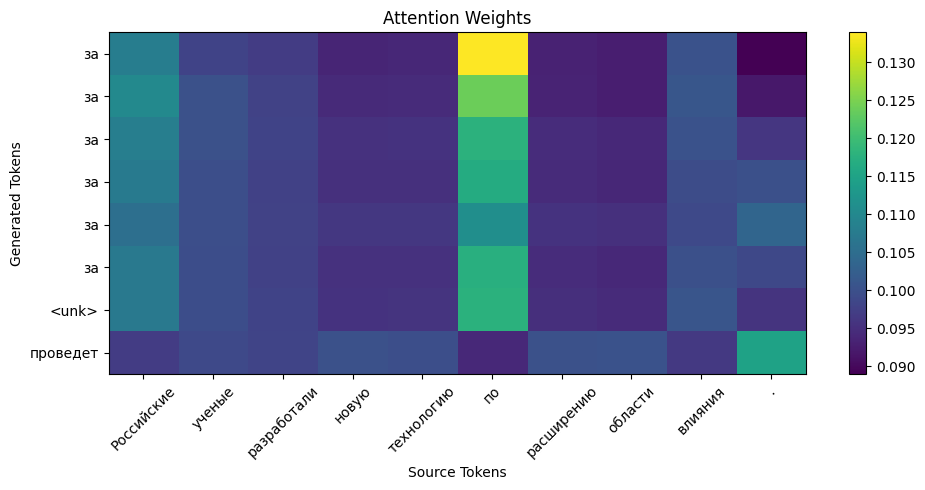

In [22]:
# Пример вызова
show_attention(model, """Российские ученые разработали новую технологию по расширению области влияния.""", word_field)